## Six-bar Mechanism Balancing

In [1]:
from BetaShF import ShF
from BetaShM import ShM 
import numpy as np 
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

### Contraints

$-0.16m <= x_{cn},y_{cn} <= 0.16m$

$0.005m <= t_{cn} <= 0.04m$

### Objective Function

In [2]:
def objective_function(s, ShF, ShM): #c is a constant that distributes the weight among the functions.
    c = 0.5
    return c*ShF(s) + c*ShM(s)

### Differential Evolution

In [14]:
# Bounds for each variable
nVar = 5
bounds = []
for i in range(1,nVar*3+1):
    if(i%3==0): bounds.append([0.005,0.04])
    else: bounds.append([-0.16, 0.16])
#print(bounds)


In [9]:
it = 5
n = 100
sols = np.zeros((n, 2))
best, bestSol = 10, None
for i in range(n):
    r = differential_evolution(objective_function, bounds, args=(ShF, ShM), maxiter=it)
    sols[i][0], sols[i][1] = ShF([*r['x']]), ShM([*r['x']])
    if r['fun'] < best:
        best = r['fun']
        bestSol = r

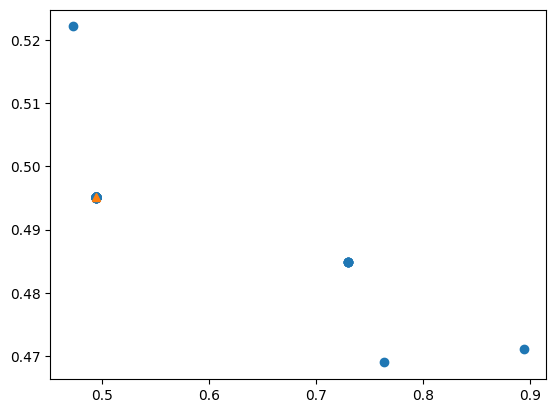

In [58]:
np.savetxt('Solutions.txt', sols, delimiter=', ')   # X is an array

plt.plot(sols[:, 0], sols[:, 1], 'o')
plt.plot(ShF([*bestSol['x']]), ShM([*bestSol['x']]), '^')

In [11]:
np.sqrt(best)

0.7031525142382722

In [12]:
bestSol

     fun: 0.49442345827960354
     jac: array([-4.85167462e-05, -5.33462163e-06, -5.98481253e-01, -4.48419080e-05,
       -9.46132062e-05,  8.29392110e-05,  6.69797551e-05, -5.24580379e-05,
       -1.66415768e+00, -4.78672657e-05,  3.45445894e-05,  5.55111512e-09,
        3.19744231e-06, -2.16660023e-05,  0.00000000e+00])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 2710
     nit: 5
 success: False
       x: array([-2.53963929e-02, -3.41818242e-02,  4.00000000e-02, -7.95848122e-02,
       -8.41851557e-03,  3.00691346e-02, -5.78430159e-02,  6.23265802e-03,
        4.00000000e-02, -2.22163786e-07,  1.51958113e-07,  1.38293965e-02,
        2.80239530e-08, -2.27563590e-07,  5.00000013e-03])

### Gradient Descent

In [ ]:
eps = 1e-5
def Vf(X,f):
    n = len(X)
    G = np.zeros((n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        G[i] = (f(X+incX)-f(X))/eps
        incX[i] = 0
    return G

def VfTd(X,d,f):
    return (f(X+eps*d)-f(X))/eps

def V2f(X,f):
    n = len(X)
    H = np.zeros((n,n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        H[:,i] = (Vf(X+incX,f)-Vf(X,f))/eps
        incX[i] = 0
    return H

def V2fTd(X,d,f):
    return (Vf(X+eps*d,f)-Vf(X,f))/eps
    
X = np.array([2,3])
d = np.array([5,1])
print('f:',f(X))
print('Vf:',Vf(X,f))
print('V2f:',V2f(X,f))
print('VfTd:',VfTd(X,d,f))
print('V2fTd:',V2fTd(X,d,f))

In [13]:
def gradient_descent(x_0, max_iter, alpha):
    i=0
    while(i < max_iter):
        
        i+=1
    return x_0

In [ ]:
max_iter = 10
alpha = 0.1

gradient_descent(bestSol, max_iter, alpha)